# writeup about the problem

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('fivethirtyeight')

import pandas as pd
import seaborn as sns



# 1. Data Loading

In [2]:
# read data
data = pd.read_csv('train.csv')
# read in genre mapping file
genre_mapping = pd.read_csv('genre-mapping.csv', index_col = 'ID').to_dict()['Genre']
# map genre and add to the data
data['Genre'] = data['Class'].apply(lambda x: genre_mapping[x]).astype('category')

# delete Class column - replaced by Genre column
del data['Class']
# delete mode column - no documentation on what the feature means
del data['mode']

In [117]:
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Genre,Duration
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,0.0485,0.017100,NaN,0.0849,0.8990,134.071,4,HipHop,3.909933
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,4,Rock,4.195550
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,4,Indie Alt,1.827783
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0.0555,0.021200,NaN,0.1220,0.5690,107.033,4,HipHop,2.899467
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,4,Rock,3.832667


In [3]:
## convert key and time signature to a category so that are not considered ordinal
data['key'] = data['key'].astype('category')
data['time_signature'] = data['time_signature'].astype('category')

In [4]:
data.dtypes

Artist Name             object
Track Name              object
Popularity             float64
danceability           float64
energy                 float64
key                   category
loudness               float64
speechiness            float64
acousticness           float64
instrumentalness       float64
liveness               float64
valence                float64
tempo                  float64
duration_in min/ms     float64
time_signature        category
Genre                 category
dtype: object

In [131]:
# get list of genres
genres = data['Genre'].unique().tolist()

# get list of features
features = data.select_dtypes(include=['float64']).columns.tolist()


# what the data colum represents

# 2. Data Cleaning

## 2.1 Summaries

/Users/krishna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


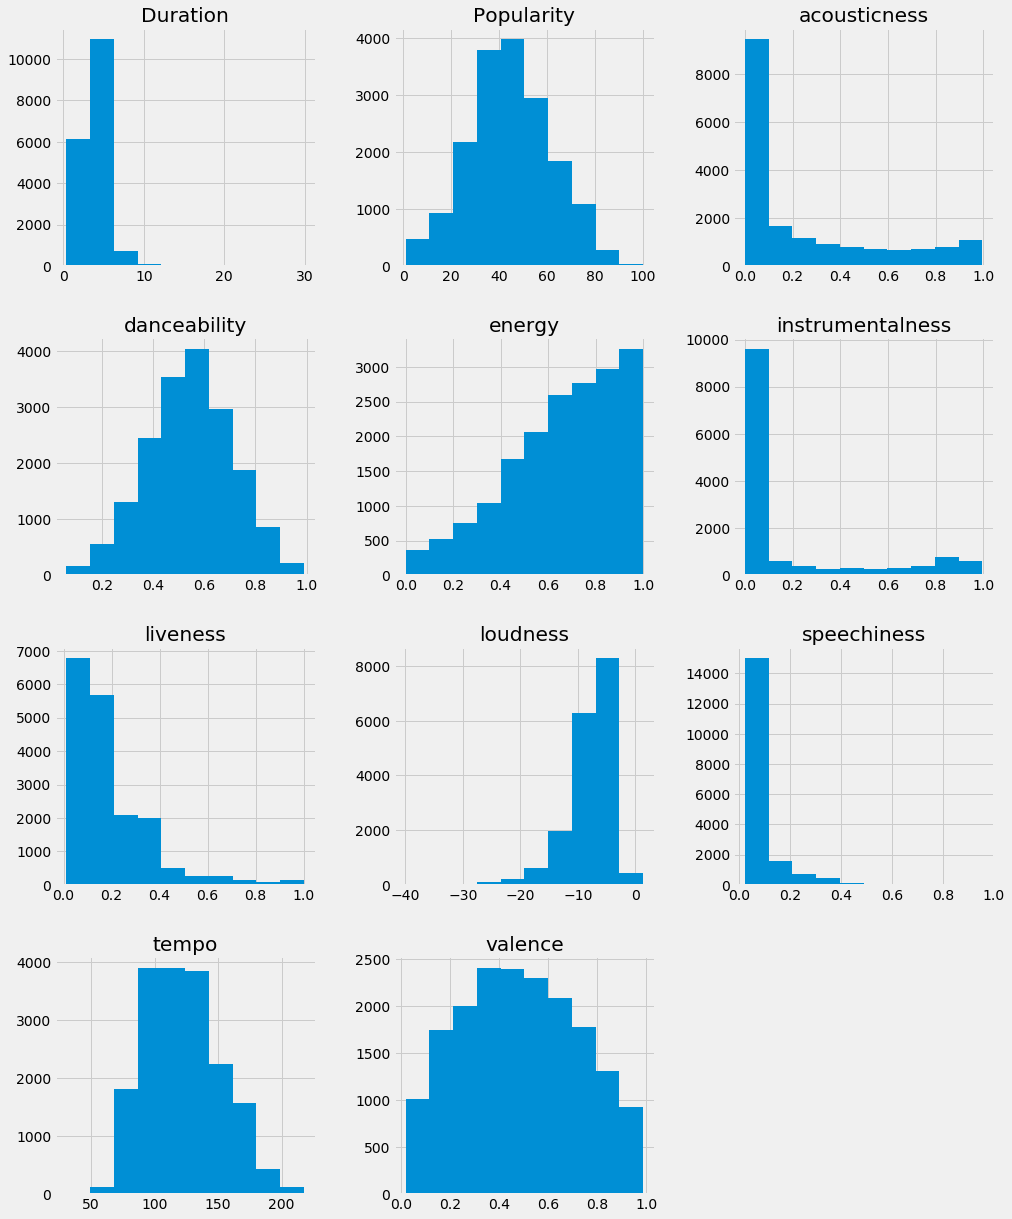

In [119]:
fig,ax = plt.subplots(figsize = (15,20))

# plot histogram of all features with floats
data[features].hist(ax = ax);

In [6]:
# output basic stats for each feature

data[features].agg(['min','mean','median','max'])

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms
min,1.000000,0.059600,0.000020,-39.95200,0.022500,0.000000,0.000001,0.01190,0.018300,30.557000,5.016500e-01
mean,44.512124,0.543433,0.662777,-7.91066,0.079707,0.247082,0.177562,0.19617,0.486208,122.623294,2.007445e+05
median,44.000000,0.545000,0.700000,-7.01600,0.047400,0.081400,0.003910,0.12900,0.481000,120.065500,2.091600e+05
max,100.000000,0.989000,1.000000,1.35500,0.955000,0.996000,0.996000,1.00000,0.986000,217.416000,1.477187e+06


## 2.2 Fix Duration Column

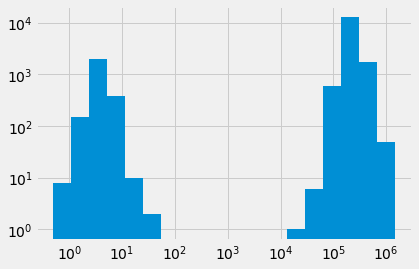

In [7]:
# get duration column
x = data['duration_in min/ms']

# make 20 logbins from the minimum to the maximum duration
logbins = np.geomspace(x.min(), x.max(), 20)

# plot bins on a logscale in order to make the bins look equal width
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.yscale('log')


In [8]:
# find some boundaries on where there is data

pd.DataFrame(pd.cut(data['duration_in min/ms'], logbins)).groupby('duration_in min/ms').size()

duration_in min/ms
(0.502, 1.099]                  7
(1.099, 2.406]                149
(2.406, 5.27]                2034
(5.27, 11.543]                377
(11.543, 25.28]                10
(25.28, 55.367]                 2
(55.367, 121.263]               0
(121.263, 265.586]              0
(265.586, 581.675]              0
(581.675, 1273.96]              0
(1273.96, 2790.175]             0
(2790.175, 6110.924]            0
(6110.924, 13383.892]           0
(13383.892, 29312.843]          1
(29312.843, 64199.766]          6
(64199.766, 140607.651]       609
(140607.651, 307953.015]    13012
(307953.015, 674465.855]     1738
(674465.855, 1477187.0]        49
dtype: int64

In [9]:
## double check that we are capturing all of the data with the boundaries

# create upper and lower bound
f1 = data['duration_in min/ms'] <= 55.367
f2 = data['duration_in min/ms'] >= 13383.892

# print shape of data to see if it matches the original dataset
data[f1 | f2].shape

(17996, 16)

In [10]:
# for the large time values, convert to minutes
# low values are assumed to be minutes
data['Duration'] = data['duration_in min/ms'].apply(lambda x: x if x <= 55.367 else x/60000)

# delete original column
del data['duration_in min/ms']

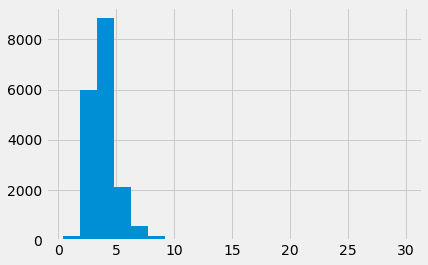

In [11]:
# plot histogram of new duration
data['Duration'].hist(bins = 20)

## 2.3 Missing Data

In [12]:
# find how many missing values there are per column

data.isnull().sum()

Artist Name            0
Track Name             0
Popularity           428
danceability           0
energy                 0
key                 2014
loudness               0
speechiness            0
acousticness           0
instrumentalness    4377
liveness               0
valence                0
tempo                  0
time_signature         0
Genre                  0
Duration               0
dtype: int64

# 3. Exploratory Data Analysis

In [13]:
# calculate the amount of data in each genre
data.groupby('Genre').size().sort_values(ascending = False)

Genre
Rock             4949
Indie Alt        2587
Pop              2524
Metal            1854
HipHop           1447
Alt_Music        1373
Blues            1272
Acoustic/Folk     625
Instrumental      576
Bollywood         402
Country           387
dtype: int64

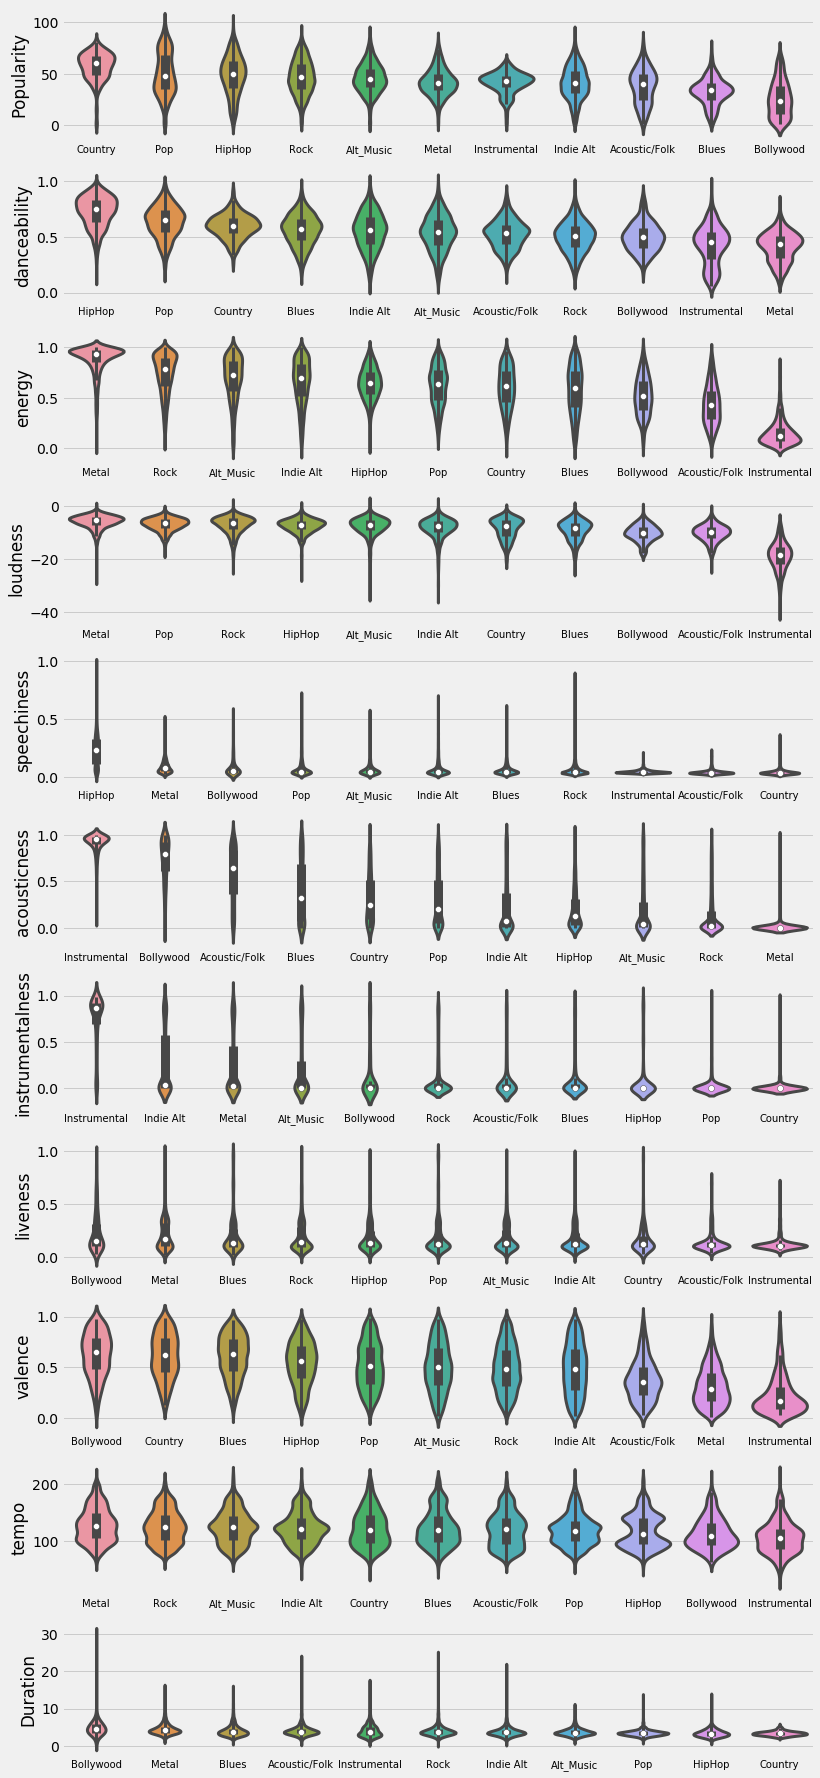

In [144]:
# configure plot
fig,axes = plt.subplots(len(features),1,figsize = (12,30))

# loop through all of the features
for i,feature in enumerate(features):
    
    # sort the genres by mean descending order of the features
    order = data.groupby(by=["Genre"])[feature].mean().sort_values(ascending = False).index
    # plot violin plots for each genre
    plot = sns.violinplot(x="Genre", y=feature, data=data, order = order, ax=axes[i], linewidth=3)
    # change x tick label size
    plot.set_xticklabels(plot.get_xmajorticklabels(), fontsize = 10)
    plot.set_xlabel('');

# 4.  Classification

In [23]:
# import necessary sklearn modules

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [145]:
# build list of classifiers
classifiers = ['KNN','LogReg','SVC','RandForest','ADA','GNB']

# build dictionary of instances of each classifier
classifier_instances = {
    'KNN': KNeighborsClassifier(),
    'LogReg':LogisticRegression(multi_class = 'ovr'),
    'SVC': SVC(),
    'RandForest':RandomForestClassifier(),
    'ADA': AdaBoostClassifier(),
    'GNB': GaussianNB(),
}

# build dictionary of parameters to grid search for each classifier
parameters = {
    'KNN': {'KNN__n_neighbors':[1,5,10,15,20,25]},
    'LogReg':{'LogReg__C': [0.1 * x for x in range(1,11)]},
    'SVC': {'SVC__C':[10**-2,10**-1,10**0,10**1,10**2]},
    'RandForest':{'RandForest__max_depth':[2,4,6,8,10]},
    'ADA': {'ADA__learning_rate':[10**-2,10**-1,10**0,10**1,10**2]},
    'GNB': {},
}

# build dictionary to store trained model for each classifier
trained_models = {
    'KNN': None,
    'LogReg':None,
    'SVC': None,
    'RandForest':None,
    'ADA': None,
    'GNB': None,
}

In [146]:
# create feature array
X = data[features].dropna()
# create target array
y = data.iloc[X.index]['Genre']

# split data into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ksplits = StratifiedShuffleSplit()
splits = list(ksplits.split(X_train,y_train))
pipeline_base = [('scalar',StandardScaler(with_mean=False))]

for classifier in classifiers:
    print(classifier)
    
    pipeline_addition = [(classifier,classifier_instances[classifier])]
    pipeline = Pipeline(pipeline_base + pipeline_addition)
    model = GridSearchCV(estimator=pipeline, cv = splits, param_grid=parameters[classifier],verbose = 1)
    model.fit(X_train,y_train)
    trained_models[classifier] = model
    

KNN
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogReg
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   38.0s finished


SVC
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


RandForest
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   54.0s finished


ADA
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:557: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:557: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boo

GNB
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


# Results

In [147]:
score_keys = ['split{}_test_score'.format(x) for x in range(10)]
scores = {classifier:None for classifier in classifiers}


for classifier in classifiers:
    best_index = trained_models[classifier].best_index_
    results = trained_models[classifier].cv_results_
    scores[classifier] = [results[key][best_index] for key in score_keys]
    
scores = pd.DataFrame(scores).T

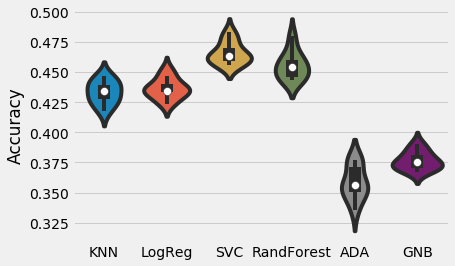

In [148]:
fig, ax = plt.subplots()

scores_reformat = pd.melt(scores.reset_index(), id_vars='index', value_vars=range(10))
ax = sns.violinplot(x="index", y= 'value', data=scores_reformat)
ax.set_xlabel('');
ax.set_ylabel('Accuracy');

In [149]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [150]:
f1s = {classifier:None for classifier in classifiers}


for classifier in classifiers:
    y_pred = trained_models[classifier].predict(X_test)
    f1s[classifier] = f1_score(y_test, y_pred, average=None, labels = genres)

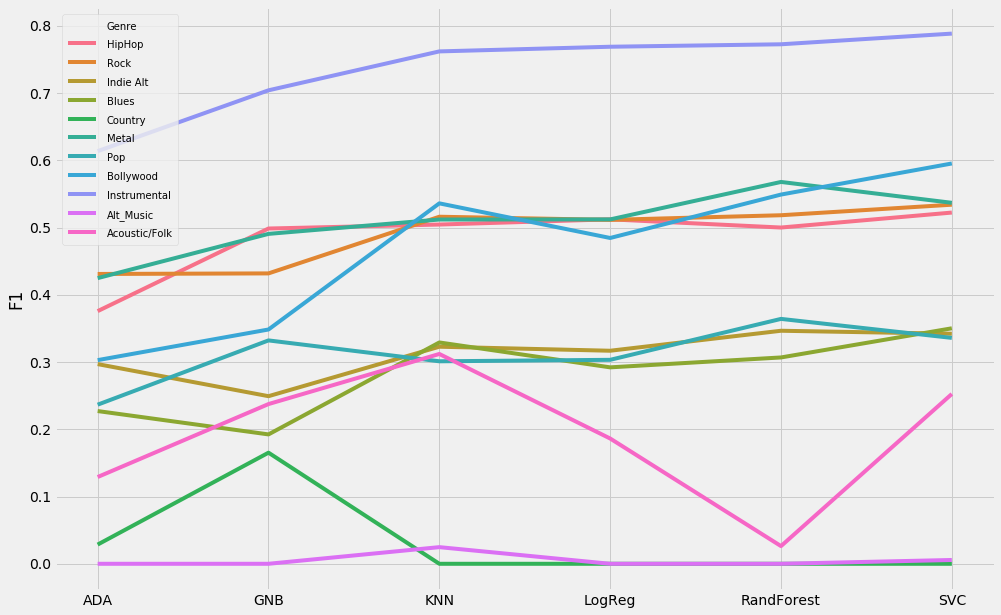

In [151]:
f1sT = pd.DataFrame(f1s).T
f1sT.columns = genres

fig, ax = plt.subplots(figsize = (15,10))

f1s_reformat = pd.melt(f1sT.reset_index(), id_vars='index', value_vars=genres)
f1s_reformat.rename(columns = {"variable":"Genre"}, inplace = True)

ax = sns.lineplot(x="index", y= 'value', data=f1s_reformat, hue='Genre')
plt.setp(ax.get_legend().get_texts(), fontsize='10') 
ax.set_xlabel('');
ax.set_ylabel('F1');